# Prepare Feature and labels

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
   print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [3]:
# Create subsequences / sampling windows with shift=1
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [5]:
# cut down the length of each column to the shortest
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [7]:
# mapping into list
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [9]:
# x and y using list slicing mapping
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [10]:
# shuffle
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())


[1 2 3 4] [5]
[0 1 2 3] [4]
[4 5 6 7] [8]
[3 4 5 6] [7]
[2 3 4 5] [6]
[5 6 7 8] [9]


In [13]:
# input x and label y
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(3).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())


x =  [[3 4 5 6]
 [5 6 7 8]
 [1 2 3 4]]
y =  [[7]
 [9]
 [5]]
x =  [[0 1 2 3]
 [2 3 4 5]
 [4 5 6 7]]
y =  [[4]
 [6]
 [8]]


# Prediction Using single layer NN

## Create an arbitrary signal data serie

In [15]:
# helper func to plot time serie data
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [18]:
# helper func to generate data
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """an arbitrary pattern for the development of the signal in each season"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * np.pi),
                    1 / np.exp(season_time/2))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """some random noise"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [28]:
# total time
time = np.arange(4 * 365 + 1, dtype="float32")
# general trend of the data series
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
# how strong the added noise should be
noise_level = 3

# Create the series (365days)
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=25)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

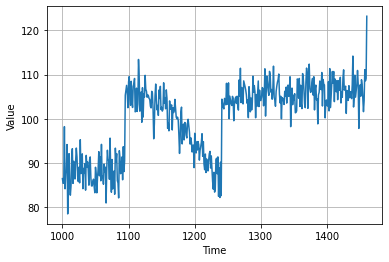

In [29]:
# original data series
plot_series(time_valid, x_valid)

## Sampling window

In [32]:
# Tuneable parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# helper func -- sampling
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # overall series: np.array
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Model

In [38]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([
                                  l0 ])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)) # Tuneable params
model.fit(dataset,epochs=100,verbose=0) # epochs tuneable

print("Layer weights {}".format(l0.get_weights()))



<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.18621594],
       [ 0.03524851],
       [ 0.00563801],
       [-0.02380647],
       [ 0.02890022],
       [ 0.07377054],
       [ 0.21150067],
       [ 0.17049807],
       [-0.19656095],
       [-0.11869758],
       [-0.05971693],
       [-0.09831491],
       [ 0.18656062],
       [-0.0193273 ],
       [ 0.25959957],
       [ 0.11380538],
       [ 0.07094043],
       [ 0.0056828 ],
       [ 0.41741836],
       [ 0.11878934]], dtype=float32), array([0.00546609], dtype=float32)]


## Predict

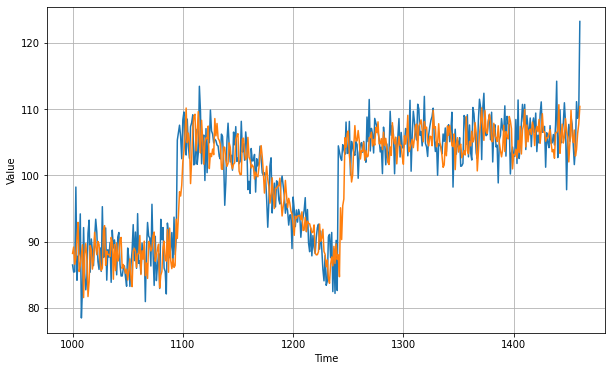

In [39]:
forecast = []

for time in range(len(series) - window_size): # iterates through all windows
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [40]:
# Loss
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.2031546

# Using DNN

## Model

In [41]:
model_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model_DNN.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model_DNN.fit(dataset,epochs=100,verbose=0)

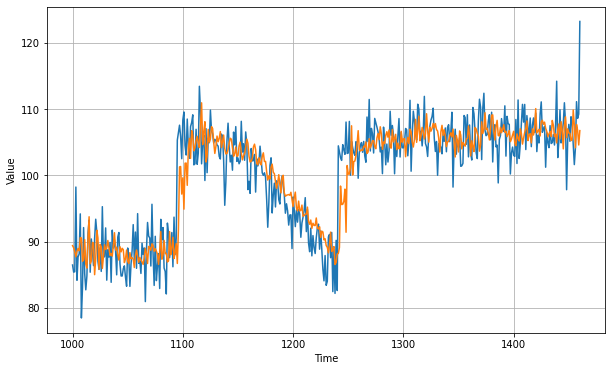

In [45]:
forecast_DNN = []
for time in range(len(series) - window_size):
  forecast_DNN.append(model_DNN.predict(series[time:time + window_size][np.newaxis]))

forecast_DNN = forecast_DNN[split_time-window_size:]
results_DNN = np.array(forecast_DNN)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results_DNN)

In [46]:
tf.keras.metrics.mean_absolute_error(x_valid, results_DNN).numpy()

3.0180688

## Using LearningRateScheduler to choose the optimal LR

In [68]:
tf.keras.backend.clear_session()
# same DNN model
model_LrDecay = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# create callbacks.LearningRateScheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9) # original lr
model_LrDecay.compile(loss="mse", optimizer=optimizer)
history = model_LrDecay.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0) # callback to control learning rate decary

In [ ]:
# find the optimal lr
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [67]:
# try the optimal lr with 500 epochs

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_LrDecay.compile(loss="mse", optimizer=optimizer)
history = model_LrDecay.fit(dataset, epochs=500, verbose=0)

In [ ]:
# check training loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [ ]:
# zoom in without the first 200 (at beginning the loss is relative high and not stabil)
loss = history.history['loss']
epochs = range(200, len(loss))
plot_loss = loss[200:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [ ]:
forecast_LrDecay = []
for time in range(len(series) - window_size):
  forecast_LrDecay.append(model_LrDecay.predict(series[time:time + window_size][np.newaxis]))

forecast_LrDecay = forecast_LrDecay[split_time-window_size:]
results_LrDecay = np.array(forecast_LrDecay)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results_LrDecay)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results_LrDecay).numpy()

# Using RNN layers

In [70]:
tf.keras.backend.clear_session()
tf.random.set_seed(30)
np.random.seed(30)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  # input to RNN (3 dimentions): Batch_size, the number of timestamps, the series dimensionality. input_shape = [None] --> model can take sequences with any length                                  
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Create correct input dimension, 
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True), 
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0) # increase the scales of the output to the scales of time series values such as 50s, 60s, 70s
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 11ms/step - loss: 77.8278 - mae: 78.3260
Epoch 2/400
8/8 [==============================] - 0s 10ms/step - loss: 40.5808 - mae: 41.0792
Epoch 3/400
8/8 [==============================] - 0s 10ms/step - loss: 27.2454 - mae: 27.7425
Epoch 4/400
8/8 [==============================] - 0s 10ms/step - loss: 16.5970 - mae: 17.0925
Epoch 5/400
8/8 [==============================] - 0s 10ms/step - loss: 14.1252 - mae: 14.6170
Epoch 6/400
8/8 [==============================] - 0s 12ms/step - loss: 12.8133 - mae: 13.3072
Epoch 7/400
8/8 [==============================] - 0s 10ms/step - loss: 12.7611 - mae: 13.2508
Epoch 8/400
8/8 [==============================] - 0s 10ms/step - loss: 12.5763 - mae: 13.0686
Epoch 9/400
8/8 [==============================] - 0s 10ms/step - loss: 11.6528 - mae: 12.1455
Epoch 10/400
8/8 [==============================] - 0s 10ms/step - loss: 11.9604 - mae: 12.4513
Epoch 11/400
8/8 [==============================]

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# zoom in
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()